In [1]:
# パッケージ
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, SimpleRNN, GRU
from keras import optimizers
from keras.callbacks import EarlyStopping

2023-05-22 23:02:16.231432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 23:02:17.880973: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
target_data = pd.read_csv("./target/target_USDJPY.csv")
#----OPTIONS----
unitsRNN      = 90
learning_rate = 0.001
patience      = 20
epochs        = 2000
batch_size    = 60
maxlen = 10

In [3]:
'''
1. データの準備
'''

x = [target_data["deviation_rate"][i:i+maxlen].values for i in range(59, len(target_data["deviation_rate"].values[:])-maxlen)]
# x = []
# for i in range(59, len(target_data["deviation_rate"].values[:])-maxlen):
#     ilist = pd.DataFrame(data={
#         "deviation_rate": target_data["deviation_rate"][i:i+maxlen].values,
#         "volume": target_data["volume"][i:i+maxlen].values
#     })
#     x.append(ilist)
t = [target_data["rise_rate"][i+maxlen-1] for i in range(59, len(target_data["rise_rate"].values[:])-maxlen)]

x = np.array(x).reshape(-1, maxlen, 1)
t = np.array(t).reshape(-1, 1)
print(x.shape, t.shape)

x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.2, shuffle=False)

(18242, 10, 1) (18242, 1)


In [4]:
'''
2. モデルの構築
'''
model = Sequential()
model.add(LSTM(unitsRNN, activation='tanh',
                recurrent_activation='sigmoid',
                kernel_initializer='he_normal',
                recurrent_initializer='orthogonal'))
model.add(Dense(1, activation='linear'))
model.add(Activation('sigmoid'))

2023-05-22 23:02:20.179393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-22 23:02:20.409584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-22 23:02:20.409657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-22 23:02:20.413274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-22 23:02:20.413409: I tensorflow/compile

In [5]:
'''
3. モデルの学習
'''
optimizer = optimizers.Adam(learning_rate=learning_rate,
                              beta_1=0.9, beta_2=0.999, amsgrad=True)

model.compile(optimizer=optimizer,
            loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',
                patience=patience,
                verbose=1)

hist = model.fit(x_train, t_train,
                epochs=epochs, batch_size=batch_size,
                verbose=2,
                validation_data=(x_val, t_val),callbacks=[es])

Epoch 1/2000


2023-05-22 23:02:24.965408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 23:02:24.966731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 23:02:24.968919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

244/244 - 7s - loss: 0.2509 - val_loss: 0.2421 - 7s/epoch - 29ms/step
Epoch 2/2000
244/244 - 2s - loss: 0.2505 - val_loss: 0.2403 - 2s/epoch - 8ms/step
Epoch 3/2000
244/244 - 2s - loss: 0.2502 - val_loss: 0.2587 - 2s/epoch - 8ms/step
Epoch 4/2000
244/244 - 2s - loss: 0.2499 - val_loss: 0.2506 - 2s/epoch - 8ms/step
Epoch 5/2000
244/244 - 2s - loss: 0.2498 - val_loss: 0.2500 - 2s/epoch - 8ms/step
Epoch 6/2000
244/244 - 2s - loss: 0.2496 - val_loss: 0.2421 - 2s/epoch - 7ms/step
Epoch 7/2000
244/244 - 2s - loss: 0.2499 - val_loss: 0.2484 - 2s/epoch - 8ms/step
Epoch 8/2000
244/244 - 2s - loss: 0.2498 - val_loss: 0.2430 - 2s/epoch - 8ms/step
Epoch 9/2000
244/244 - 2s - loss: 0.2497 - val_loss: 0.2464 - 2s/epoch - 7ms/step
Epoch 10/2000
244/244 - 2s - loss: 0.2497 - val_loss: 0.2445 - 2s/epoch - 7ms/step
Epoch 11/2000
244/244 - 2s - loss: 0.2499 - val_loss: 0.2458 - 2s/epoch - 10ms/step
Epoch 12/2000
244/244 - 2s - loss: 0.2497 - val_loss: 0.2505 - 2s/epoch - 8ms/step
Epoch 13/2000
244/244 - 

 38/571 [>.............................] - ETA: 1s

2023-05-22 23:07:16.464209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 23:07:16.465954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 23:07:16.466974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

571/571 [==============================] - 2s 3ms/step


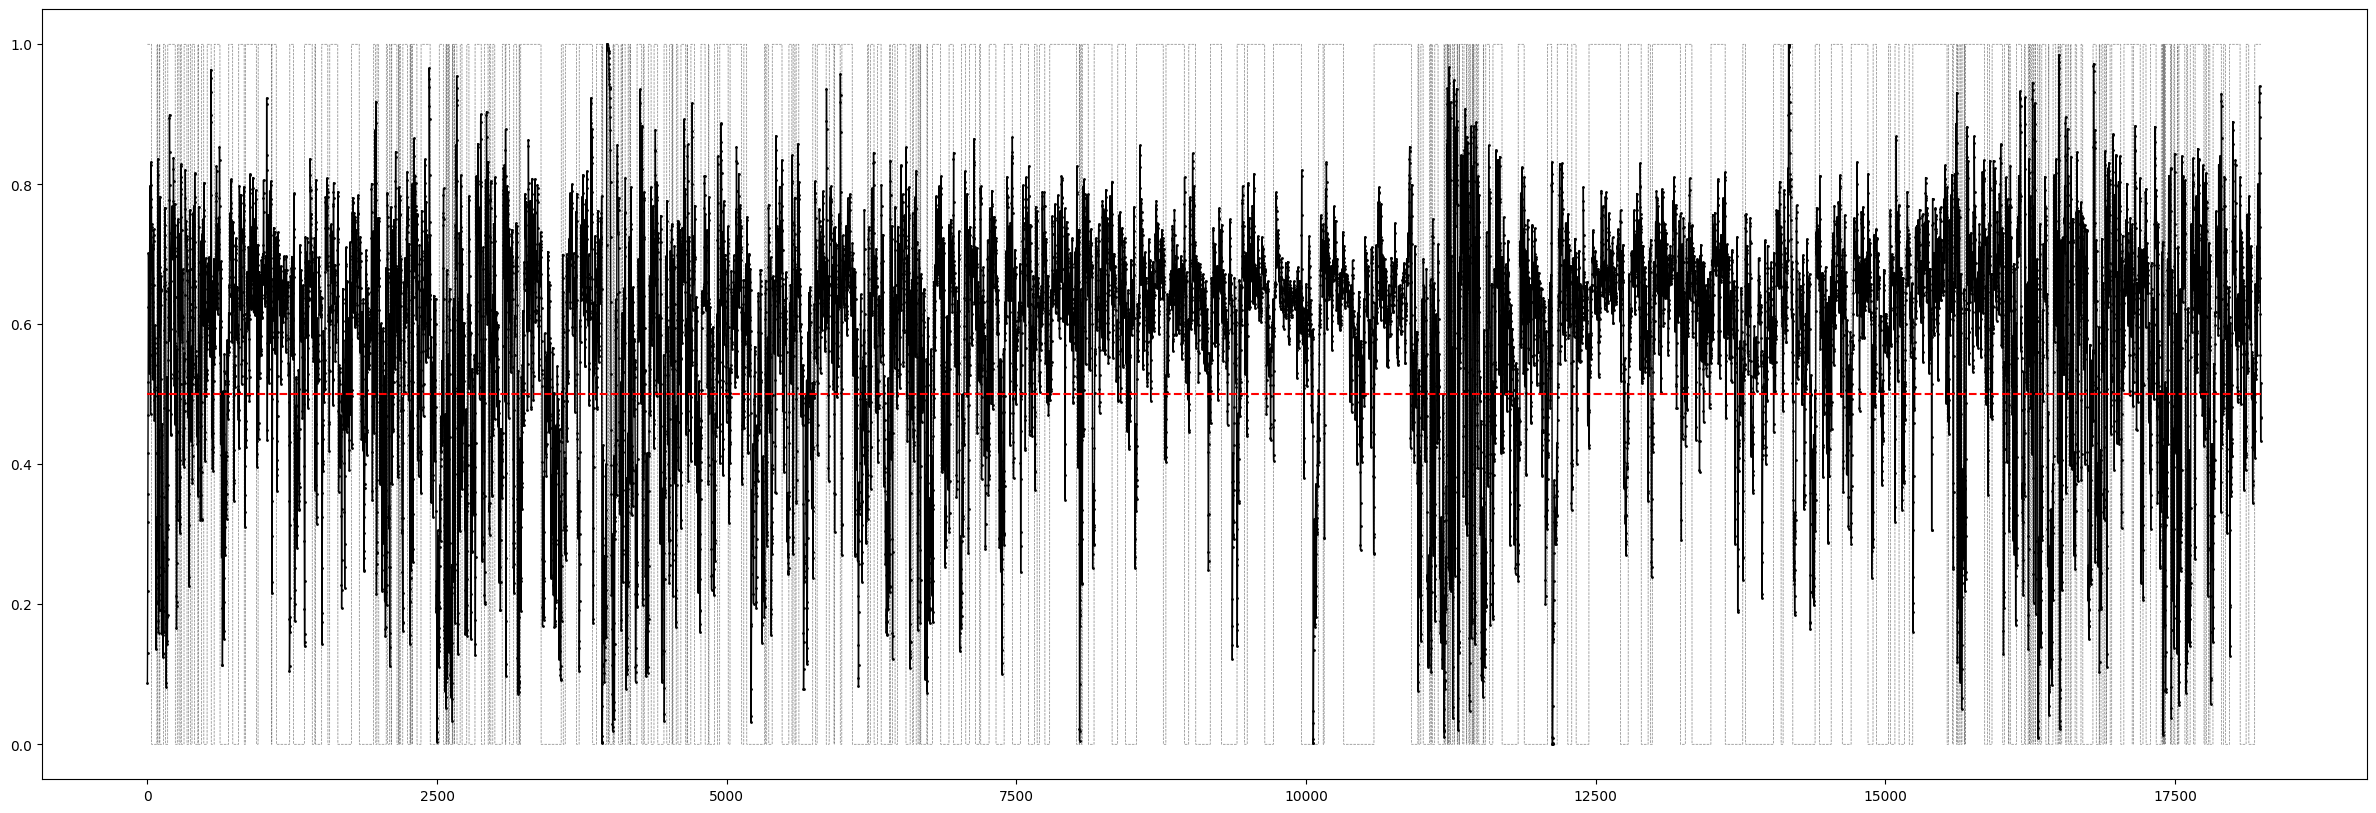

In [6]:
'''
4. モデルの評価
'''
indata = t
predicted = []

preds = model.predict(x)
for i in range(len(preds)):
    predicted.append(preds[i])


# 予測値を可視化
fig = plt.figure(figsize=(30, 10))
plot_length = len(predicted)
plt.plot(range(plot_length), indata[:plot_length],
        color='gray',
        linestyle='--', linewidth=0.5)
plt.plot(range(plot_length), predicted[:plot_length],
        color='black', linewidth=1,
        marker='o', markersize=1, markerfacecolor='black',
        markeredgecolor='black')
plt.plot([0, plot_length],[0.5, 0.5], "red", linestyle='dashed')
plt.show()

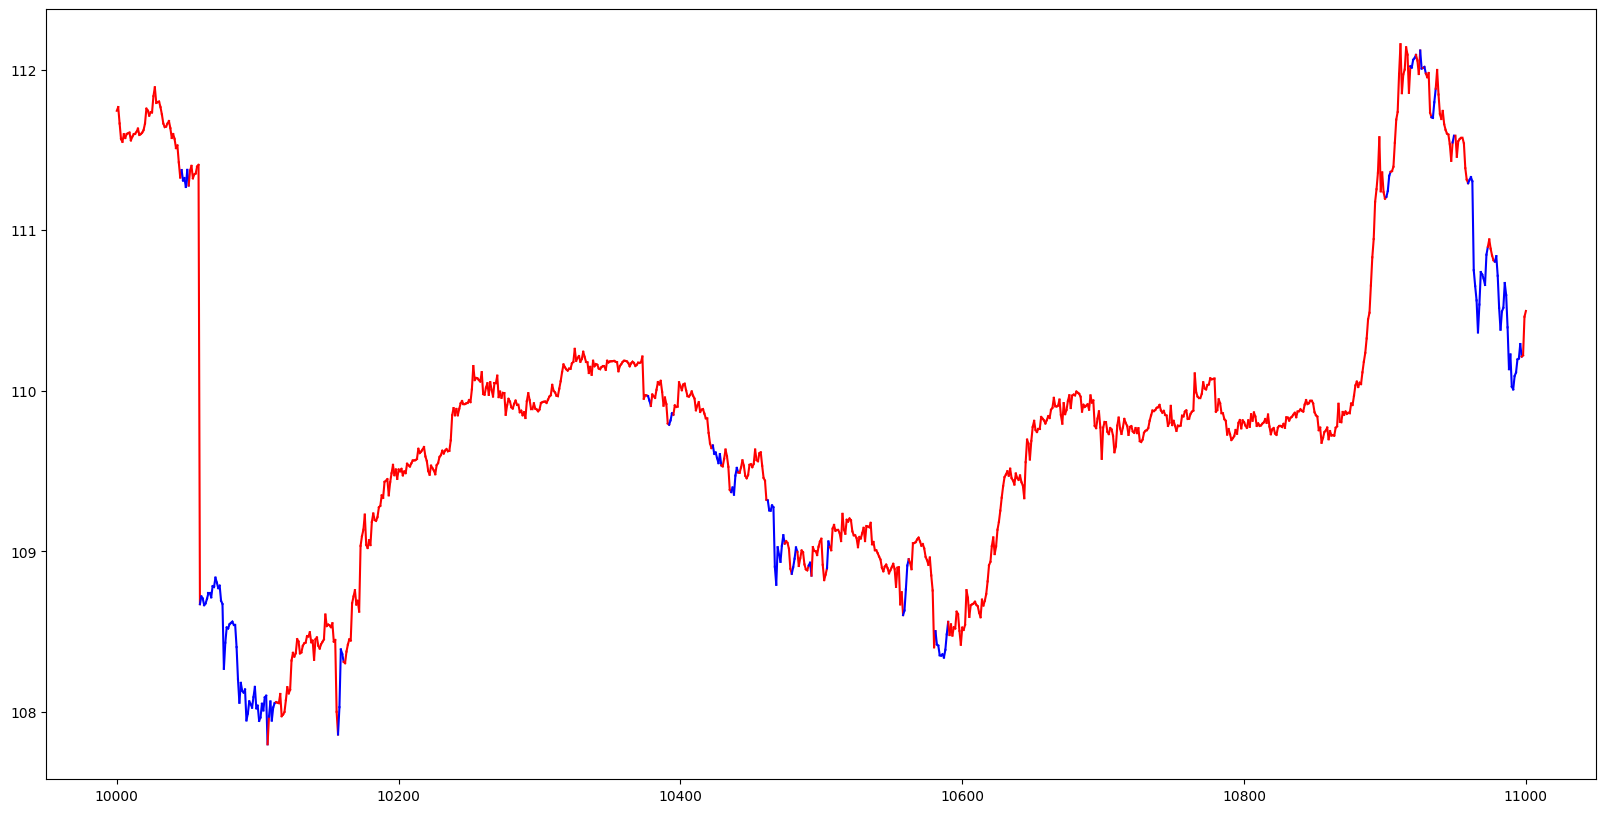

In [7]:
# 実データに反映し描画
chart = [target_data["close"][i+maxlen-1] for i in range(59, len(target_data["close"].values[:])-maxlen)]
fig = plt.figure(figsize=(20,10))
plot_length = len(chart)
for i in range(10000,11000):
    plt.plot(range(plot_length+1)[i:i+2], chart[i:i+2], color= 'red' if predicted[i] > 0.5 else 'blue')
plt.show()

In [8]:
# 売買シミュレーション
#---OPTIONS---
total   = 10000     # 初期金額
per     = 0.1       # 1回の投資金額
per_lot = 10000     # 1ロット当たりの通貨数
leverage = 10        # レバレッジ(整数)
losscut = 0.995     # ロスカットする比率
position = None     # ポジションの状態（"Buy","Sell",None）買い,売り,無し
position_data = None  # 現在のポジションの情報[index, 取引時価格, lot数]
recent_position = None # 直近のポジション
result_history = [] # シミュレーションの結果を記録
win     = 0         # ポジションを変更したときに利益がプラスの回数
lose    = 0         # ポジションを変更したときに利益がマイナスの回数
tax     = 0         # 支払った税金
lscount = 0         # ロスカットの回数

chart = [target_data["close"][i+maxlen-1] for i in range(59, len(target_data["close"].values[:])-maxlen)]
chart_high = [target_data["high"][i+maxlen-1] for i in range(59, len(target_data["high"].values[:])-maxlen)]
chart_low = [target_data["low"][i+maxlen-1] for i in range(59, len(target_data["low"].values[:])-maxlen)]
for i in range(12000, len(predicted)):
    flag_losscut = False
    # ロスカット計算
    if position in ["Buy", "Sell"]:
        if position == "Buy":
            if position_data[1] * losscut > chart_low[i]:
                #total += (chart[i] - position_data[1]) * position_data[2] * per_lot
                total += position_data[1] * (1-losscut) * position_data[2] * per_lot
                flag_losscut = True
        
        elif position == "Sell":
            if position_data[1] * (2-losscut) < chart_high[i]:
                #total += (position_data[1] - chart[i]) * position_data[2] * per_lot
                total += position_data[1] * (1-losscut) * position_data[2] * per_lot
                flag_losscut = True
    
    # ロスカットがなければ取引実行
    if not flag_losscut:
        if position == None:
            if predicted[i] > 0.5:
                position = "Buy"
            else:
                position = "Sell"
            # if predicted[i] > 0.5 and recent_position != "Buy":
            #     position = "Buy"
            # elif recent_position != "Sell":
            #     position = "Sell"
                
            # 何ロット？
            lots = (total * per * leverage / chart[i]) / per_lot
            position_data = [i, chart[i], lots]
                
        elif position == "Buy":
            if predicted[i] < 0.5 or (chart[i] - position_data[1])/position_data[1] > 0.01:
                # 直前のポジションを決済
                profit = (chart[i] - position_data[1]) * position_data[2] * per_lot
                total += profit
                if profit > 0:
                    win += 1
                else:
                    lose += 1
                position = "Sell"
                # 何ロット？
                lots = (total * per * leverage / chart[i]) / per_lot
                position_data = [i, chart[i], lots]
                
        elif position == "Sell":
            if predicted[i] > 0.5 or (position_data[1] - chart[i])/position_data[1] > 0.01:
                # 直前のポジションを決済
                profit =(position_data[1] - chart[i]) * position_data[2] * per_lot
                total += profit
                if profit > 0:
                    win += 1
                else:
                    lose += 1
                position = "Buy"
                # 何ロット？
                lots = (total * per * leverage / chart[i]) / per_lot
                position_data = [i, chart[i], lots]
        else:
            print(ValueError)
    else:
        # print("losscut")
        recent_position = position
        position = None
        lose += 1
        lscount += 1
    
    # 記録
    result_history.append(total)

print(f"勝利：{win}")
print(f"敗北：{lose}")
print(f"最終金額：{total}")

勝利：180
敗北：278
最終金額：18985.261420843224


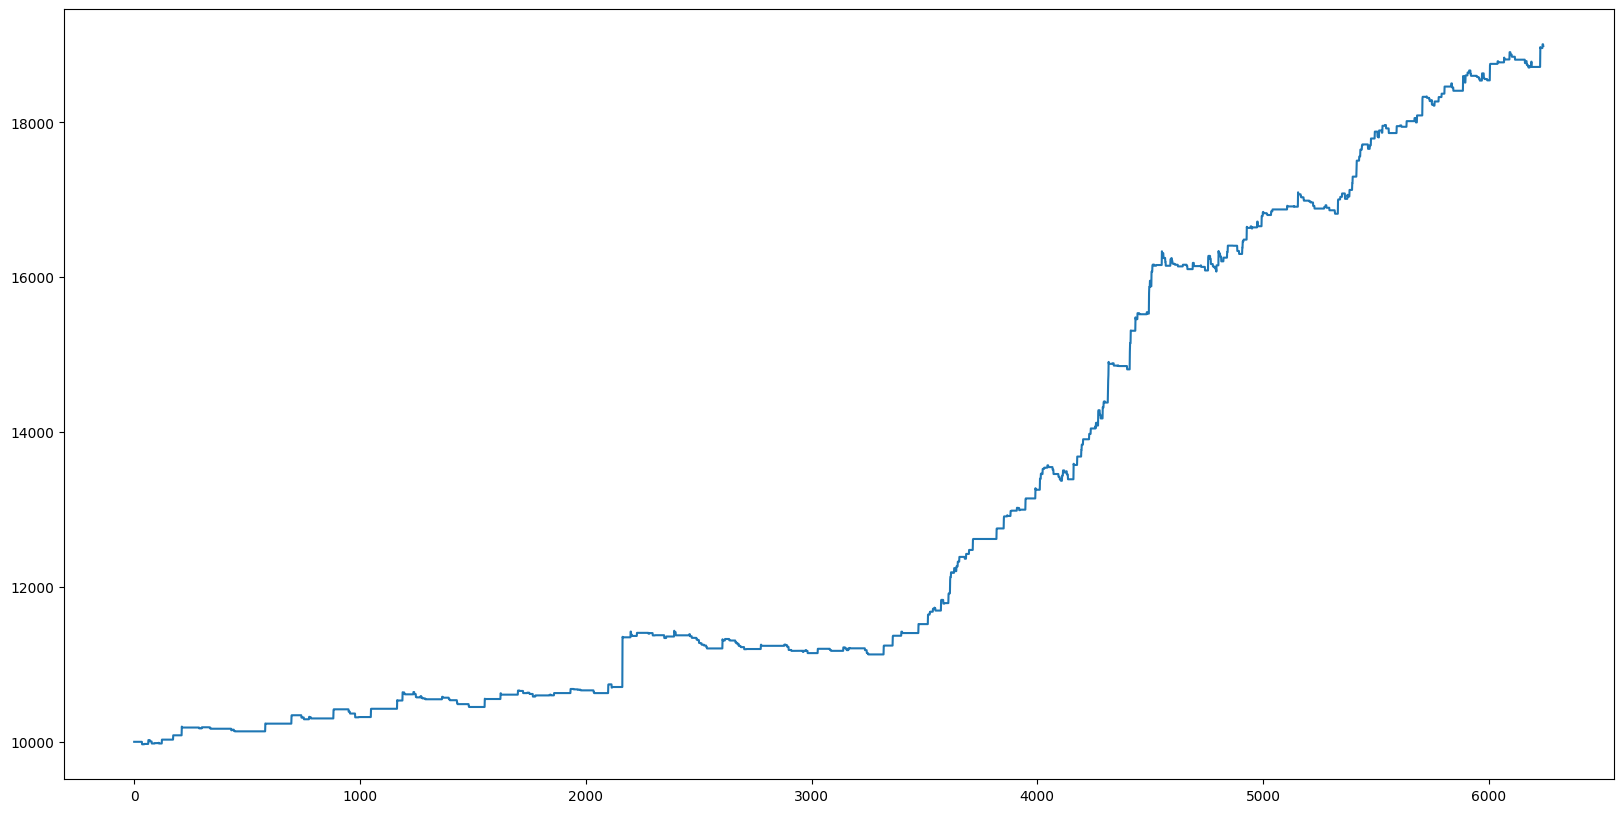

In [9]:
# シミュレーションの推移
fig = plt.figure(figsize=(20,10))
plt.plot(result_history)
plt.show()

In [13]:
# 保存先がなければ作成
dir_path = f"../models"
dir = Path(dir_path)
dir.mkdir(parents=True, exist_ok=True)
# 現在の日時をつけて保存
today = datetime.now()
file_name = today.strftime("%Y%m%d_%H%M%S")
model.save(f"{dir_path}/model_{file_name}.h5")